In [1]:
import openmm as mm
import numpy as np
import openmm.app as app
import simtk.unit as unit
from openmmforcefields.generators import GAFFTemplateGenerator as gen
from openff.toolkit import Topology
import pytraj as pt
import os
import matplotlib.pyplot as plt

from openmm.app import CharmmPsfFile, CharmmCrdFile, CharmmParameterSet



In [2]:
base = '/scratch/htc/fsafarov/structures/8ef5_july_2025/8ef5'

#We use psf and crd system because pdb files does not support the 6-digit base system for ATOM ID's, which is in our case utilized for POPC. 
#Input below is from psf and crd from CHARMM-GUI.

psf = CharmmPsfFile(os.path.join(base, 'step5_assembly.psf'))
crd = CharmmCrdFile(os.path.join(base, 'step5_assembly.crd'))



/scratch/htc/fsafarov/openmm_ff/lib/python3.12/site-packages/openmm/app/charmmparameterset.py:391: UserWarning: Replacing dihedral <DihedralType: k=0.27; phase=180.0; per=2> with <DihedralType: k=0.03; phase=180.0; per=2>
  warnings.warn('Replacing dihedral %r with %r' %
/scratch/htc/fsafarov/openmm_ff/lib/python3.12/site-packages/openmm/app/charmmparameterset.py:391: UserWarning: Replacing dihedral <DihedralType: k=0.0; phase=0.0; per=3> with <DihedralType: k=0.12; phase=0.0; per=3>
  warnings.warn('Replacing dihedral %r with %r' %


In [ ]:
with open('/scratch/htc/fsafarov/states/mor_simulation_1/system_npt.xml') as input:
    system = mm.XmlSerializer.deserialize(input.read())

In [ ]:
state = mm.XmlSerializer.deserialize(open('/scratch/htc/fsafarov/states/mor_simulation_1/npt_eq_1.xml').read())
centered_positions = state.getPositions()

In [12]:
integrator_eq = mm.LangevinIntegrator(100*unit.kelvin, 1/unit.picoseconds, 2.0*unit.femtoseconds)

In [14]:
platform = mm.Platform.getPlatformByName('CUDA')
#to run the simulation on several GPU's parallelly
properties  = {'CudaDeviceIndex': '0,1,2', 'CudaPrecision': 'mixed'}

In [15]:
#loads checkpoint if exists
simulation_eq = app.Simulation(psf.topology, system, integrator_eq, platform, properties)
simulation_eq.loadCheckpoint('/scratch/htc/fsafarov/traj/mor_simulation_suru_prot/checkpoint_pr_npt_1.chk')
state_1 = simulation_eq.context.getState(getVelocities=True)
velocities = state_1.getVelocities(asNumpy = True)


In [ ]:
for i in reversed(range(system.getNumForces())):
    force = system.getForce(i)
    if isinstance(force, mm.MonteCarloBarostat):
        system.removeForce(i)

In [ ]:
for i in range(system.getNumForces()):
    force = system.getForce(i)
    print(force)

In [ ]:
#Add a barostat with a surface tension
system.addForce(mm.MonteCarloMembraneBarostat(
    1000*unit.bar,
    0.005*unit.dyne/unit.centimeter,
    100*unit.kelvin,
    mm.MonteCarloMembraneBarostat.XYIsotropic,
    mm.MonteCarloMembraneBarostat.ZFree
))

In [ ]:
#Whenever changes made to the system, we should reinitialize. Context has some cached data from previous simulations when chk is uploaded, so it needs to be updated to the current system.
simulation_eq.context.reinitialize()
simulation_eq.context.setPositions(centered_positions)
simulation_eq.context.setVelocities(velocities)

In [ ]:
simulation_eq.context.setParameter('k_2', 10.0*unit.kilocalories_per_mole/unit.angstrom**2)
simulation_eq.context.setParameter('k_1', 2.0*unit.kilocalories_per_mole/unit.angstrom**2)

In [ ]:
a_vec, b_vec, c_vec = state.getPeriodicBoxVectors()

simulation_eq.context.setPeriodicBoxVectors(a_vec,b_vec,c_vec)

In [ ]:
dict(simulation_eq.context.getParameters()) #check the padrameters!!!

In [ ]:
#check the forces
state_2 = simulation_eq.context.getState(getForces=True, getEnergy=True)
forces = state_2.getForces(asNumpy = True).value_in_unit(unit.kilojoule/unit.nanometer/unit.mole)
norm = np.linalg.norm(forces, axis = 1)
max_force = max(norm)
np.argmax(norm), np.max(norm)

In [ ]:
#check energy
print("Potential energy:", state_2.getPotentialEnergy())
print("Kinetic energy:", state_2.getKineticEnergy())

In [22]:
simulation_eq.reporters.append(app.DCDReporter('/scratch/htc/fsafarov/traj/mor_simulation_suru_prot/trajectory_pr_npgt_1.dcd', 1000, enforcePeriodicBox=True))
simulation_eq.reporters.append(app.CheckpointReporter('/scratch/htc/fsafarov/traj/mor_simulation_suru_prot/checkpoint_pr_npgt_1.chk', 1000))
simulation_eq.step(50000)


In [ ]:
simulation_eq.saveState('/scratch/htc/fsafarov/states/mor_simulation_1/npgt_eq_1.xml')

In [ ]:
with open('/scratch/htc/fsafarov/states/mor_simulation_1/system_npgt.xml', 'w') as f:
    f.write(mm.XmlSerializer.serialize(system))

(array([1.72202789e-02, 8.28108951e-02, 2.00830131e-01, ...,
        0.00000000e+00, 0.00000000e+00, 1.09683305e-04]),
 array([0.01821176, 0.09529747, 0.17238318, ..., 7.57261104, 7.64969675,
        7.72678246]),
 <BarContainer object of 100 artists>)

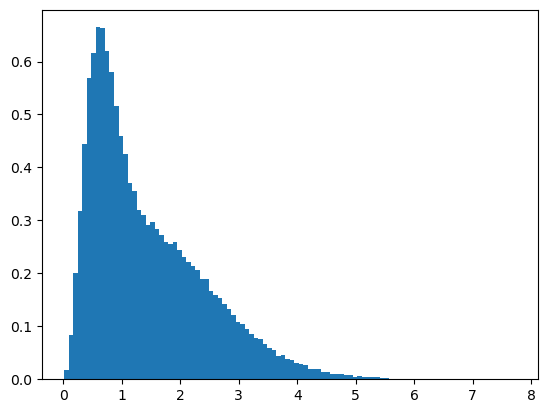

In [23]:
state_1 = simulation_eq.context.getState(getVelocities=True)
velocities = state_1.getVelocities().value_in_unit(unit.nanometer/unit.picosecond)
speed = np.linalg.norm(velocities, axis = 1)
plt.hist(speed, 100, density = True)
plt.grid()



In [24]:
# simulation_eq.currentStep